<a href="https://colab.research.google.com/github/rajan-dhinoja/Sales_Prediction_using_ML/blob/main/sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Sales_Prediction_using_ML (Regression Project)**
---



# ***Step-A: Data Preprocessing:-***

## Step-1: Import Required Dependencies:-
Import essential libraries and modules for data manipulation, visualization, and preprocessing...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
import warnings
warnings.filterwarnings('ignore')

# Set the option to prevent silent downcasting
np.set_printoptions(formatter={'float': '{:,.2f}'.format}, suppress=True, precision=2)
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('future.no_silent_downcasting', True)

print("\t ✅ Required Libraries are Imported - Done!\n")

	 ✅ Required Libraries are Imported - Done!



## Step-2: Load the Dataset and Display Different overviews of Datasets:-

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dataset = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Datasets/REGRESSION/Big_Mart_Sales/train_data.csv'))
dataset.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


In [3]:
# Seperate the whole datset into categorical and numerical columns...

categorical_cols = dataset.select_dtypes(include=['object']).columns
numerical_cols = dataset.select_dtypes(exclude=['object']).columns

if categorical_cols.empty:
  print("❌ No Categorical Columns Found...")
else:
  print("✅ Categorical Columns found: \n", categorical_cols, "\n")

if numerical_cols.empty:
  print("❌ No Numerical Columns Found...")
else:
  print("✅ Numerical Columns found: \n", numerical_cols)

✅ Categorical Columns found: 
 Index(['ProductID', 'FatContent', 'ProductType', 'OutletID', 'OutletSize',
       'LocationType', 'OutletType'],
      dtype='object') 

✅ Numerical Columns found: 
 Index(['Weight', 'ProductVisibility', 'MRP', 'EstablishmentYear',
       'OutletSales'],
      dtype='object')


In [4]:
print("> Shape of the Dataset: ", dataset.shape, "\n")
print("> Information about Dataset:")
print(dataset.info(), "\n")
print("> Statistical summary of the Dataset:")
# print(dataset.describe().map(lambda x: round(x, 4)))
print(dataset.describe())

> Shape of the Dataset:  (8523, 12) 

> Information about Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProductID          8523 non-null   object 
 1   Weight             7060 non-null   float64
 2   FatContent         8523 non-null   object 
 3   ProductVisibility  8523 non-null   float64
 4   ProductType        8523 non-null   object 
 5   MRP                8523 non-null   float64
 6   OutletID           8523 non-null   object 
 7   EstablishmentYear  8523 non-null   int64  
 8   OutletSize         6113 non-null   object 
 9   LocationType       8523 non-null   object 
 10  OutletType         8523 non-null   object 
 11  OutletSales        8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None 

> Statistical summary of the Dataset:
        Weight  ProductVisibility      MRP  E

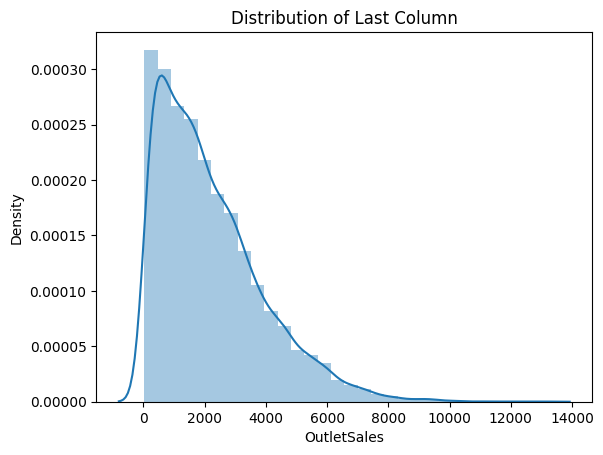

In [5]:
# plt.figure(figsize=(10, 6))
sns.distplot(dataset.iloc[:, -1], bins=30, kde=True)
plt.title('Distribution of Last Column')
plt.show()

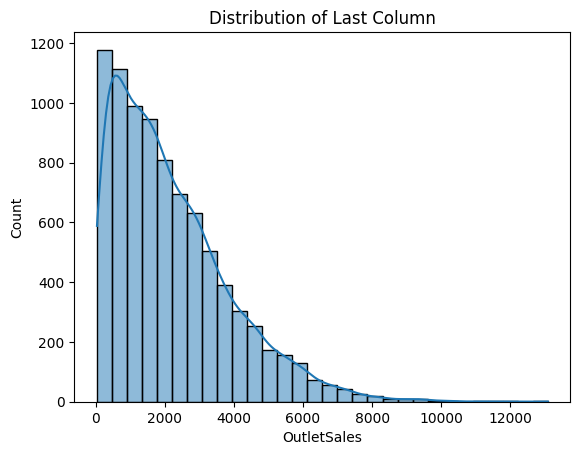

In [6]:
# Plot target distribution
sns.histplot(dataset.iloc[:, -1], bins=30, kde=True)
plt.title('Distribution of Last Column')
plt.show()

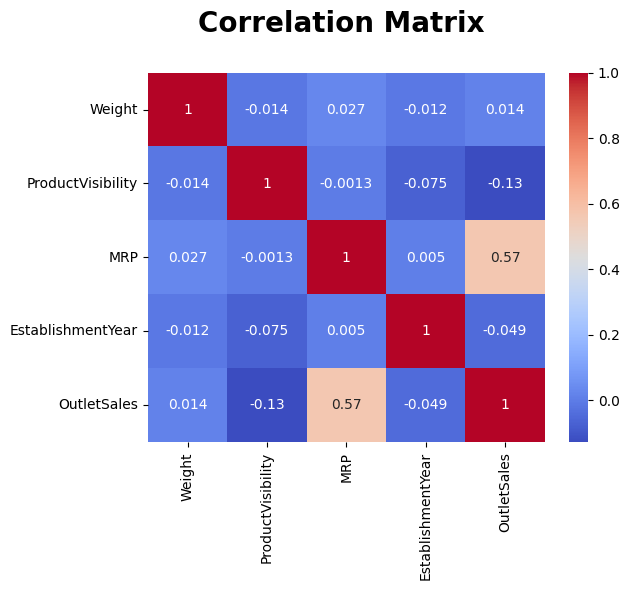

In [7]:
# Correlation Matrix Heatmap
sns.heatmap(dataset[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix \n',fontsize=20,  fontweight=800)
plt.show()

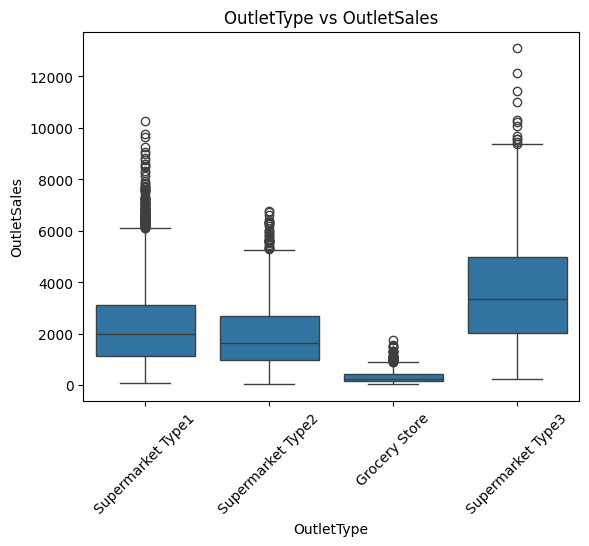

In [8]:
# Boxplot for OutletType vs OutletSales
# plt.figure(figsize=(10, 6))
sns.boxplot(x='OutletType', y='OutletSales', data=dataset)
plt.xticks(rotation=45)
plt.title('OutletType vs OutletSales')
plt.show()

## Step-3:- Checking the Dataset:-

### Step-3.1: Checking any Duplicate Data and Handling them:-

In [9]:
if dataset.duplicated().any():
  dataset.drop_duplicates(inplace=True)
  print("✅ Duplicate Data(or Identical Rows) found and Removed...")
else:
    print("❌ No Duplicate Data(or Identical Rows) found...")

❌ No Duplicate Data(or Identical Rows) found...


### Step-3.2: Cheking any Missing Data and Handling them:-

In [10]:
# Here from the module named impute of the library scikit-learn, we are using the SimpleImputer Class to Handle the Missing Values.
from sklearn.impute import SimpleImputer

missing_data_counts = dataset.isnull().sum() + dataset.isin(['', 'N/A', 'Unknown', 'NaN']).sum()

# if dataset.isnull().values.any() or dataset.isin(['', 'NaN', 'N/A', 'Unknown']).any().any():
if missing_data_counts.any():

  categorical_missing_counts = dataset[categorical_cols].isnull().sum() + dataset[categorical_cols].isin(['', 'N/A', 'Unknown', 'NaN']).sum()
  numerical_missing_counts = dataset[numerical_cols].isnull().sum()

  # Replace "Unknown" with NaN in categorical columns
  for col in categorical_cols:
    dataset[col] = dataset[col].replace('Unknown', np.nan)


  # Check if there are any missing values (categorical or numerical)
  if categorical_missing_counts.any() or numerical_missing_counts.any():
      # Print missing counts for categorical columns in the desired format
      print("⚠️ Missing Data Found! Handling them...\n")
      print("Missing Data Counts in Categorical Columns: \n", categorical_missing_counts)
      print("\n")
      print("Missing Data Counts in Numerical Columns: \n", numerical_missing_counts)
      print("\n")

      # Create imputers for categorical and numerical features
      categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
      numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

      # Apply imputers to the selected columns in X
      if len(categorical_cols) > 0:
        categorical_cols_for_impution = [col for col in categorical_cols if col != dataset.columns[-1]]
        dataset[categorical_cols_for_impution] = categorical_imputer.fit_transform(dataset[categorical_cols_for_impution])

      # Exclude the dependent variable column (last column) if it's numerical
      numerical_cols_for_impution = [col for col in numerical_cols if col != dataset.columns[-1]]
      if len(numerical_cols_for_impution) > 0:
          dataset[numerical_cols_for_impution] = numerical_imputer.fit_transform(dataset[numerical_cols_for_impution])
      # if len(numerical_cols) > 0:
          # dataset[numerical_cols] = numerical_imputer.fit_transform(dataset[numerical_cols])
      print("✅ Missing Data Handled Successfully...")
      print("New Data with replaced missing values: \n", dataset.head(10).to_string(header=True))
else:
    print("❌ No missing data found...")



⚠️ Missing Data Found! Handling them...

Missing Data Counts in Categorical Columns: 
 ProductID          0
FatContent         0
ProductType        0
OutletID           0
OutletSize      2410
LocationType       0
OutletType         0
dtype: int64


Missing Data Counts in Numerical Columns: 
 Weight               1463
ProductVisibility       0
MRP                     0
EstablishmentYear       0
OutletSales             0
dtype: int64


✅ Missing Data Handled Successfully...
New Data with replaced missing values: 
   ProductID  Weight FatContent  ProductVisibility            ProductType    MRP OutletID  EstablishmentYear OutletSize LocationType         OutletType  OutletSales
0     FDA15    9.30    Low Fat               0.02                  Dairy 249.81   OUT049           1,999.00     Medium       Tier 1  Supermarket Type1     3,735.14
1     DRC01    5.92    Regular               0.02            Soft Drinks  48.27   OUT018           2,009.00     Medium       Tier 3  Supermarket Type2    

### Step-3.3: Checking any Synonyms or Aliases and Handling them:-

In [11]:
# for col in dataset.columns:
#   # Get value counts and convert to DataFrame with column name
#   # .reset_index(name='Counts: '): This converts the Series into a DataFrame and names the count column as 'Counts: '.
#   value_counts_dataset = dataset[col].value_counts().rename_axis('Unique Values: ').reset_index(name='Counts: ')

#   # Transpose and print with formatting
#   print(f"Column: \t\t'{col}'")
#   # .to_string(header=False): This converts the transposed DataFrame to a string for printing and removes the header row.
#   print(value_counts_dataset.T.to_string(header=False), "\n")


In [12]:
# # Handling ProductID Column
dataset['ProductID'] = dataset['ProductID'].apply(lambda x: x[:2])
# dataset['ProductID'] = dataset['ProductID'].map({'FD': 'Food', 'NC': 'Non-Consumable', 'DR': 'Drinks'})
print("> After Handling the Prefixes of 'ProductID' Column and changed to new Name: {'FD': 'Food', 'NC': 'Non-Consumable', 'DR': 'Drinks'}...")
print(dataset['ProductID'].value_counts())

print("\n")

# Handling FatContent Column
dataset['FatContent'] = dataset['FatContent'].replace({ 'LF': 'Low Fat', 'low fat': 'Low Fat', 'Low fat': 'Low Fat', 'reg': 'Regular'})
dataset.loc[dataset['ProductID'] == 'NC', 'FatContent'] = 'Non-Edible'
print("> After Handling the Aliases of 'FatContent' Column: Low Fat and Regular & Adding a new Category: Non-Edible...")
print(dataset['FatContent'].value_counts())

print("\n")

# Handling EstablishmentYear Column
import datetime as dt
current_year = dt.datetime.today().year
dataset['OutletAge'] = current_year - dataset['EstablishmentYear']
dataset = dataset.drop('EstablishmentYear', axis=1)
print("> 'EstablishmentYear' column is Deleted, Instead 'OutletAge' column is created...")
# print(dataset['OutletAge'].value_counts())
outlet_age_counts = dataset['OutletAge'].value_counts().rename_axis('Age').reset_index(name='Counts')
print("Outlet Age: \n", outlet_age_counts.to_string(index=False))  # Print without row index

> After Handling the Prefixes of 'ProductID' Column and changed to new Name: {'FD': 'Food', 'NC': 'Non-Consumable', 'DR': 'Drinks'}...
ProductID
FD    6125
NC    1599
DR     799
Name: count, dtype: int64


> After Handling the Aliases of 'FatContent' Column: Low Fat and Regular & Adding a new Category: Non-Edible...
FatContent
Low Fat       3918
Regular       3006
Non-Edible    1599
Name: count, dtype: int64


> 'EstablishmentYear' column is Deleted, Instead 'OutletAge' column is created...
Outlet Age: 
   Age  Counts
40.00    1463
38.00     932
26.00     930
28.00     930
21.00     930
23.00     929
16.00     928
18.00     926
27.00     555


### Step-3.4: Checking for Stopwords and Stemming them:-

In [13]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

if categorical_cols.any():

  nltk.download('stopwords')

  stop_words = set(stopwords.words('english'))
  # stop_words = stop_words.remove('not')
  print("\n Stop Words are: ", stop_words, "\n")
  def stemming(text):
      words = text.lower().split()

      stemmer = PorterStemmer()
      stemmed_words = [stemmer.stem(word) for word in words if word not in stop_words]
      return ' '.join(stemmed_words)  # Join stemmed words back into a string

  # Apply the stemming function to the specified columns
  for column in categorical_cols:
      dataset[column] = dataset[column].astype(str).apply(stemming)

  print("✅ Stemming Completed Successfully... \n")
  print(dataset.head().to_string(header=True))
else:
  print("❌ No Stemming Needed...")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



 Stop Words are:  {'don', 'both', 'yourself', "don't", "shan't", 'all', 'who', 'other', 'our', 'wasn', 'than', 'these', 'been', 'between', "hasn't", 'o', 'theirs', 'yourselves', "they've", 'hadn', 'aren', "she'd", 'y', 'couldn', 'i', 'nor', 'out', "you've", 'doesn', 'have', 're', 'shan', "isn't", 'the', 'after', 'an', 'mightn', "they'd", 'their', 'were', 'down', 'just', 'd', "needn't", 'here', 'a', 'it', "won't", 'which', "it's", "aren't", 'needn', 'mustn', 'its', 'herself', 'while', "mustn't", 'ours', "you'll", 'did', 'do', 'itself', 'from', 'only', 'has', "hadn't", "he'd", 'they', "it'll", 'most', 'below', 'isn', 'she', 'same', "it'd", 'because', "he'll", 'hers', 'there', 'ourselves', 'on', 'what', 'are', "i'm", 's', 'or', 'didn', 'this', 'to', "we'll", "she'll", 'had', 'ma', 'once', "didn't", 'am', "we're", "they're", 'such', 'about', 'during', "should've", 'more', 've', "couldn't", 'through', 'own', 'at', 'in', 'you', 'above', 'some', 'when', 'those', 'that', 'for', 'of', 'her', '

### Step-3.5: Checking any Categorical Data and Encoding them:-

In [14]:
# `sklearn.compose` is a module in scikit-learn (a popular Python machine learning library) used for combining different data transformations.
# sklearn.preprocessing is a module within scikit-learn that provides tools for preparing your data for machine learning algorithms.
# LabelEncoder is a specific class designed to convert categorical labels (like 'France', 'Spain', 'Germany') into numerical labels (like 0, 1, 2).

import scipy.sparse
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1].values

repeating_cols = []
for col in categorical_cols:
    # Matrix of Feature
    if col != dataset.columns[-1]:
      print(f"> String Values present in Column '{col}'.")
      # Check for repeating values within the categorical column
      value_counts = dataset[col].value_counts()
      repeating_values = value_counts[value_counts > 1].index.tolist()
      if repeating_values:
        repeating_cols.append(col)
        print(f"\t- Also, Categorical values found in column '{col}': {repeating_values}.")
        print(f"\t✅ '{col}' is Encoded Successfully...\n")

      else:
        print(f"\t❌ But No Categorical values found in column '{col}'.\n")

    # Dependent Variable/Output
    if col == dataset.columns[-1]:
      print(f"> String Values present in Column '{col}'(Output Column).")
      # Check for repeating values within the categorical column
      value_counts = dataset[col].value_counts()
      repeating_values = value_counts[value_counts > 1].index.tolist()
      if repeating_values:
        print(f"\t- Also, Categorical values found in column '{col}': {repeating_values}")
        le = LabelEncoder()
        y = le.fit_transform(dataset[col])
        print(f"\t✅ '{col}' is Encoded Successfully...\n")
      else:
        print(f"\t❌ But No Categorical values found in column '{col}'.\n")

print("=> Repeating Columns in Matrix of Features(X): ", repeating_cols, "\n")
if repeating_cols:
  encoder = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), repeating_cols)], remainder='passthrough')
  encoder_transform = encoder.fit_transform(X)

  # Conditional conversion to dense array
  if scipy.sparse.issparse(encoder_transform):  # Check if sparse
    X = encoder_transform.toarray()
  else:
    X = encoder_transform

else:
  print("❌ No Repeating Columns found in Matrix of Features(X). \n")

print("Matrix of Features(X): \n", pd.DataFrame(X).head().to_string(header=True))
print("\n")
print("Dependent Variable(y): \n", pd.DataFrame(y).head().to_string(header=False, index=False))


> String Values present in Column 'ProductID'.
	- Also, Categorical values found in column 'ProductID': ['fd', 'nc', 'dr'].
	✅ 'ProductID' is Encoded Successfully...

> String Values present in Column 'FatContent'.
	- Also, Categorical values found in column 'FatContent': ['low fat', 'regular', 'non-ed'].
	✅ 'FatContent' is Encoded Successfully...

> String Values present in Column 'ProductType'.
	- Also, Categorical values found in column 'ProductType': ['fruit veget', 'snack food', 'household', 'frozen food', 'dairi', 'can', 'bake good', 'health hygien', 'soft drink', 'meat', 'bread', 'hard drink', 'other', 'starchi food', 'breakfast', 'seafood'].
	✅ 'ProductType' is Encoded Successfully...

> String Values present in Column 'OutletID'.
	- Also, Categorical values found in column 'OutletID': ['out027', 'out013', 'out049', 'out046', 'out035', 'out045', 'out018', 'out017', 'out010', 'out019'].
	✅ 'OutletID' is Encoded Successfully...

> String Values present in Column 'OutletSize'.
	- 

## Step-4: Split the Dataset into the Training set and Test set:-

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Printing Training Sets: ")
print("> X_train: \n", X_train)
print("> X_test: \n", X_test, "\n")

print("\n")

print("Printing Test Sets: ")
print("> y_train: \n", y_train)
print("> y_test: \n", y_test)

Printing Training Sets: 
> X_train: 
 [[0.00 1.00 0.00 ... 0.04 171.34 2,386.23]
 [0.00 0.00 1.00 ... 0.05 170.54 3,103.96]
 [0.00 1.00 0.00 ... 0.08 111.72 1,125.20]
 ...
 [0.00 0.00 1.00 ... 0.02 237.36 6,145.33]
 [0.00 1.00 0.00 ... 0.05 117.95 1,649.85]
 [0.00 0.00 1.00 ... 0.02 95.74 965.41]]
> X_test: 
 [[0.00 1.00 0.00 ... 0.03 79.43 1,743.06]
 [0.00 0.00 1.00 ... 0.07 42.71 356.87]
 [0.00 1.00 0.00 ... 0.04 42.05 377.51]
 ...
 [0.00 1.00 0.00 ... 0.04 42.05 629.18]
 [0.00 1.00 0.00 ... 0.14 50.50 253.00]
 [0.00 1.00 0.00 ... 0.06 109.23 976.73]] 



Printing Test Sets: 
> y_train: 
 [26.00 23.00 28.00 ... 23.00 18.00 28.00]
> y_test: 
 [38.00 28.00 26.00 ... 38.00 16.00 23.00]


## Step-5: Feature Scaling:-

In [16]:
""" Here we are not applying Feature Scaling in Dependent Variable (y), because there are only 0 and 1 values in y """
# StandardScaler class from scikit-learn, which is a tool for standardization and Normalization.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Convert X_train and X_test to NumPy arrays if they are DataFrames
X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test

# Iterate through columns of X_train and X_test
for col in range(X_train.shape[1]):  # Use range to get column indices
    # Check if all values in the column are 0 or 1
    if np.all(np.isin(X_train[:, col], [0, 1])):
        continue  # Skip scaling for this column
    else:
        # Reshape the column before scaling
        X_train[:, col] = scaler.fit_transform(X_train[:, col].reshape(-1, 1)).flatten()
        X_test[:, col] = scaler.transform(X_test[:, col].reshape(-1, 1)).flatten()

print("✅ Feature Scaling is Done Successfully...\n")
print("Printing Training Sets after Feature Scaling:")
print("> X_train: \n", X_train)
print("\n")
print("Printing Test Sets after Feature Scaling:")
print("> X_test: \n", X_test)
print("\n")
print(pd.DataFrame(X).head().to_string())

✅ Feature Scaling is Done Successfully...

Printing Training Sets after Feature Scaling:
> X_train: 
 [[0.00 1.00 0.00 ... -0.60 0.47 0.11]
 [0.00 0.00 1.00 ... -0.36 0.46 0.52]
 [0.00 1.00 0.00 ... 0.19 -0.48 -0.63]
 ...
 [0.00 0.00 1.00 ... -0.92 1.53 2.29]
 [0.00 1.00 0.00 ... -0.23 -0.38 -0.32]
 [0.00 0.00 1.00 ... -0.95 -0.74 -0.72]]


Printing Test Sets after Feature Scaling:
> X_test: 
 [[0.00 1.00 0.00 ... -0.77 -1.00 -0.27]
 [0.00 0.00 1.00 ... 0.10 -1.59 -1.07]
 [0.00 1.00 0.00 ... -0.48 -1.60 -1.06]
 ...
 [0.00 1.00 0.00 ... -0.48 -1.60 -0.91]
 [0.00 1.00 0.00 ... 1.46 -1.46 -1.13]
 [0.00 1.00 0.00 ... -0.21 -0.52 -0.71]]


    0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41    42   43     44       45
0 0.00 1.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0

# ***Step-B: Model Builing & Evaluation...***

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = {
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    KNeighborsRegressor(),
    SVR(),
    GradientBoostingRegressor(),
    ElasticNet(),
    XGBRegressor(),
    # LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5),
    Ridge(),
    Lasso(),
}

# models = [
#     DecisionTreeRegressor(
#       criterion="squared_error",  # Default: minimizes MSE
#       max_depth=5,  # Limits tree depth to prevent overfitting
#       min_samples_split=10,  # Minimum samples required to split
#       min_samples_leaf=4,  # Minimum samples per leaf node
#       random_state=42
#     ),
#     RandomForestRegressor(
#       n_estimators=100,  # Number of trees in the forest
#       max_depth=5,  # Limits depth to avoid overfitting
#       min_samples_split=5,  # Minimum samples needed to split
#       min_samples_leaf=2,  # Minimum samples per leaf node
#       random_state=42,
#       n_jobs=-1  # Uses all CPU cores for faster training
#     ),
#     KNeighborsRegressor(
#       n_neighbors=5,  # Number of neighbors
#       weights="distance",  # Weighs closer neighbors more
#       algorithm="auto",  # Automatically selects the best algorithm
#       leaf_size=30
#     ),
#     SVR(
#       kernel="rbf",  # Radial Basis Function kernel for non-linearity
#       C=100,  # Regularization parameter (higher = more complexity)
#       epsilon=0.1,  # Defines margin of error
#       gamma="scale"  # Auto kernel coefficient
#     )
# ]

for model in models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  cv_score = cross_val_score(model, X_train, y_train, cv=5)
  print(f"✅ {model.__class__.__name__} is trained Sucessfully...")
  print(f"-> {model.__class__.__name__}:-")
  print(f"\t R2 Score : {r2_score(y_test, y_pred):.2f}")
  print(f"\t CV Score : {cv_score.mean()*100:.2f}%")
  print(f"\t MSE: \t\t{mean_squared_error(y_test, y_pred):.2f}")
  print(f"\t RMSE : \t{np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
  print(f"\t MAE : \t\t{mean_absolute_error(y_test, y_pred):.2f}")
  print("\n")


✅ KNeighborsRegressor is trained Sucessfully...
-> KNeighborsRegressor:-
	 R2 Score : 1.00
	 CV Score : 99.86%
	 MSE: 		0.07
	 RMSE : 	0.27
	 MAE : 		0.06


✅ LinearRegression is trained Sucessfully...
-> LinearRegression:-
	 R2 Score : 1.00
	 CV Score : 100.00%
	 MSE: 		0.00
	 RMSE : 	0.00
	 MAE : 		0.00


✅ GradientBoostingRegressor is trained Sucessfully...
-> GradientBoostingRegressor:-
	 R2 Score : 1.00
	 CV Score : 100.00%
	 MSE: 		0.00
	 RMSE : 	0.01
	 MAE : 		0.01


✅ XGBRegressor is trained Sucessfully...
-> XGBRegressor:-
	 R2 Score : 1.00
	 CV Score : 100.00%
	 MSE: 		0.00
	 RMSE : 	0.00
	 MAE : 		0.00


✅ SVR is trained Sucessfully...
-> SVR:-
	 R2 Score : 1.00
	 CV Score : 99.63%
	 MSE: 		0.18
	 RMSE : 	0.42
	 MAE : 		0.21


✅ ElasticNet is trained Sucessfully...
-> ElasticNet:-
	 R2 Score : 0.39
	 CV Score : 38.82%
	 MSE: 		41.99
	 RMSE : 	6.48
	 MAE : 		5.18


✅ Ridge is trained Sucessfully...
-> Ridge:-
	 R2 Score : 1.00
	 CV Score : 100.00%
	 MSE: 		0.00
	 RMSE : 	0.01

# ***Step-C: Saving the Model & Testing It...***

## Step-1: Saving the Model(.sav):-

In [18]:
import pickle

# Train and save models
for model in models:
    # model.fit(X_train, y_train)

    # Save each model with its name
    model_filename = f"{model.__class__.__name__}.sav"
    pickle.dump(model, open(model_filename, "wb"))

    print(f"✅ Model saved: {model_filename}")

✅ Model saved: KNeighborsRegressor.sav
✅ Model saved: LinearRegression.sav
✅ Model saved: GradientBoostingRegressor.sav
✅ Model saved: XGBRegressor.sav
✅ Model saved: SVR.sav
✅ Model saved: ElasticNet.sav
✅ Model saved: Ridge.sav
✅ Model saved: Lasso.sav
✅ Model saved: RandomForestRegressor.sav
✅ Model saved: DecisionTreeRegressor.sav


## Step-2: Predicting and Testing the Model:-

In [19]:
correct_predictions = 0
max_correct_predictions = 0
model_predictions = {} # dictionary to store model and their correct predictions

random_input = np.random.randint(2, 8)
print("Number of Inputs for Predction: ", random_input, "\n")

for i in range(random_input):

  sample_input = pd.DataFrame(X_train).iloc[i].values.reshape(1, -1)  # Convert a row to an array
  sample_output = round(y_train[i], 2)

  print("Before Predicting, Sample Data & Output Sales are:-")
  print("> Sample Data: ", sample_input)
  print("> Output: ",sample_output, "\n")

  for model in models:
    model = pickle.load(open(f"{model.__class__.__name__}.sav", "rb"))
    model_filename = f"{model.__class__.__name__}.sav"
    print(f"-> {model.__class__.__name__}:-")

    prediction = model.predict(sample_input)
    # print(" - Predicted Sales:", prediction[0])
    rounded_prediction = round(prediction[0], 2)
    print(f" - Predicted Sales: {rounded_prediction:.2f}")

    if rounded_prediction == sample_output:
        correct_predictions += 1
        print("\t✅ Nice Work! your Prediction is correct...\n")
        # increment correct prediction count for the model in the dictionary
        model_predictions[model.__class__.__name__] = model_predictions.get(model.__class__.__name__, 0) + 1
    else:
        print("\t❌ Oops! your Prediction is incorrect...\n")

  print("="*75, "\n")

Number of Inputs for Predction:  6 

Before Predicting, Sample Data & Output Sales are:-
> Sample Data:  [[0.00 1.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00
  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00 0.00 1.00 0.00 1.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 0.00
  -0.80 -0.60 0.47 0.11]]
> Output:  26.0 

-> KNeighborsRegressor:-
 - Predicted Sales: 26.00
	✅ Nice Work! your Prediction is correct...

-> LinearRegression:-
 - Predicted Sales: 26.00
	✅ Nice Work! your Prediction is correct...

-> GradientBoostingRegressor:-
 - Predicted Sales: 26.00
	✅ Nice Work! your Prediction is correct...

-> XGBRegressor:-
 - Predicted Sales: 26.00
	✅ Nice Work! your Prediction is correct...

-> SVR:-
 - Predicted Sales: 26.02
	❌ Oops! your Prediction is incorrect...

-> ElasticNet:-
 - Predicted Sales: 26.90
	❌ Oops! your Prediction is incorrect...

-> Ridge:-
 - Predicted Sales: 26.00
	✅ Nice Work! your Prediction is correct...

-> Lasso:-
 

## Step-3: Selecting the Perfect Model for this Dataset:-

In [20]:
# Instead of using max, we'll iterate and check for at least one correct prediction
models_with_correct_predictions = []  # List to store models with at least one correct prediction

for model_name, correct_count in model_predictions.items():
    if correct_count >= 1:  # Check for at least one correct prediction
        models_with_correct_predictions.append(model_name)

# Print the results
if models_with_correct_predictions:
    print("The following Models achieved at least one correct Prediction:")
    for model_name in models_with_correct_predictions:
        print(f"\t- ✅ '{model_name}': '{model_predictions[model_name]}' correct predictions")
else:
    print("No models achieved any correct predictions on the samples.")

The following Models achieved at least one correct Prediction:
	- ✅ 'KNeighborsRegressor': '6' correct predictions
	- ✅ 'LinearRegression': '6' correct predictions
	- ✅ 'GradientBoostingRegressor': '3' correct predictions
	- ✅ 'XGBRegressor': '6' correct predictions
	- ✅ 'Ridge': '5' correct predictions
	- ✅ 'RandomForestRegressor': '6' correct predictions
	- ✅ 'DecisionTreeRegressor': '6' correct predictions


---
# 🏁🎉Hurray! Your Project Work on Google Collab is Completed Successfully🎉🏁
---